### This scripts takes about 4 minutes seconds to execute

In [888]:
from tqdm.notebook import tqdm, trange
import horseracinglib
from horseracinglib import *
from importlib import reload
reload(horseracinglib)
pd.options.display.max_columns = None

# Load test data (not seen by models)

In [889]:
runners = pd.read_csv('data\\runners_test.csv', parse_dates=['meeting_date'], infer_datetime_format=True)
runners.sort_values(by=['race_id', 'runner_id'], inplace=True)
runners.head()

,runner_id,race_id,meeting_date,stall_number,gender,age,trainer_id,trainer_sr,sire_id,sire_sr,dam_id,dam_sr,finpos,win,win_perc,sp,mkt_prob,overage,adj_mkt_prob,blinkers,visor,cheekpieces,tonguetie,entire,gelding,daysLTO,position1,position2,position3,position1_1,position1_2,position1_3,position1_4,position2_1,position2_2,position2_3,position2_4,position3_1,position3_2,position3_3,position3_4
608,568961,440447,2013-01-01,3,G,10,3973,0.189024,50854,0.0,199460,0.0,1,1,0.703704,1.08,0.480769,0.693974,0.692777,0,0,0,0,0,1,15,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0
2819,720097,440447,2013-01-01,1,G,10,9509,0.053333,1213449,0.0,104420,0.0,4,0,0.000000,21.00,0.045455,0.693974,0.065499,0,0,0,0,0,1,365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3087,738609,440447,2013-01-01,2,G,8,9243,0.079691,1217252,0.0,107710,0.0,3,0,0.000000,17.00,0.055556,0.693974,0.080054,0,0,0,0,0,1,225,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0
20189,1663897,440447,2013-01-01,4,G,4,19540,0.128226,261406,0.0,64884,0.0,2,0,0.000000,9.00,0.100000,0.693974,0.144098,0,0,0,0,0,1,14,4,4,2,0,0,0,1,0,0,0,1,0,1,0,0
30270,1783909,440447,2013-01-01,5,G,5,9013,0.011111,485373,0.0,441268,0.0,5,0,0.000000,81.00,0.012195,0.693974,0.017573,0,0,0,0,0,1,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [890]:
runners_single_race = runners[runners.race_id == 440447]
runners_single_race

,runner_id,race_id,meeting_date,stall_number,gender,age,trainer_id,trainer_sr,sire_id,sire_sr,dam_id,dam_sr,finpos,win,win_perc,sp,mkt_prob,overage,adj_mkt_prob,blinkers,visor,cheekpieces,tonguetie,entire,gelding,daysLTO,position1,position2,position3,position1_1,position1_2,position1_3,position1_4,position2_1,position2_2,position2_3,position2_4,position3_1,position3_2,position3_3,position3_4
608,568961,440447,2013-01-01,3,G,10,3973,0.189024,50854,0.0,199460,0.0,1,1,0.703704,1.08,0.480769,0.693974,0.692777,0,0,0,0,0,1,15,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0
2819,720097,440447,2013-01-01,1,G,10,9509,0.053333,1213449,0.0,104420,0.0,4,0,0.000000,21.00,0.045455,0.693974,0.065499,0,0,0,0,0,1,365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3087,738609,440447,2013-01-01,2,G,8,9243,0.079691,1217252,0.0,107710,0.0,3,0,0.000000,17.00,0.055556,0.693974,0.080054,0,0,0,0,0,1,225,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0
20189,1663897,440447,2013-01-01,4,G,4,19540,0.128226,261406,0.0,64884,0.0,2,0,0.000000,9.00,0.100000,0.693974,0.144098,0,0,0,0,0,1,14,4,4,2,0,0,0,1,0,0,0,1,0,1,0,0
30270,1783909,440447,2013-01-01,5,G,5,9013,0.011111,485373,0.0,441268,0.0,5,0,0.000000,81.00,0.012195,0.693974,0.017573,0,0,0,0,0,1,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Demonstrate calculating model probabilities for single race

In [891]:
my_multinomial_logit = MultinomialLogitModel('models\\multinomial_logit_coefficients.csv', model_prefix='ML')
display(my_multinomial_logit.model_coefficients)
my_multinomial_logit.calculate_model_probabilities_for_single_race(runners_single_race)

,feature,coefficient
0,age,-0.027801
1,trainer_sr,5.300271
2,daysLTO,-0.000583
3,position1_1,0.548396
4,position1_2,0.539932
5,position1_3,0.324656
6,position1_4,-0.218123
7,position2_1,0.202110
8,position2_2,0.180563
9,position2_3,0.087636


,race_id,runner_id,stall_number,win,mod_prob
608,440447,568961,3,1,0.558904
2819,440447,720097,1,0,0.091615
3087,440447,738609,2,0,0.097166
20189,440447,1663897,4,0,0.152579
30270,440447,1783909,5,0,0.099735


In [892]:
my_random_choice = RandomChoiceModel(model_prefix='RC')
display(my_random_choice.model_coefficients)
my_random_choice.calculate_model_probabilities_for_single_race(runners_single_race)

None

,race_id,runner_id,stall_number,win,mod_prob
608,440447,568961,3,1,0.091704
2819,440447,720097,1,0,0.306744
3087,440447,738609,2,0,0.233697
20189,440447,1663897,4,0,0.137597
30270,440447,1783909,5,0,0.230258


In [893]:
my_favourite_choice = FavouriteChoiceModel(model_prefix='FC')
display(my_favourite_choice.model_coefficients)
my_favourite_choice.calculate_model_probabilities_for_single_race(runners_single_race)

None

,race_id,runner_id,stall_number,win,mod_prob
608,440447,568961,3,1,0.692777
2819,440447,720097,1,0,0.065499
3087,440447,738609,2,0,0.080054
20189,440447,1663897,4,0,0.144098
30270,440447,1783909,5,0,0.017573


# Demonstrate calculating model probabilities for multiple races

In [894]:
my_multinomial_logit.calculate_model_probabilities_for_multiple_races(runners)
my_multinomial_logit.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,440447,568961,3,1,0.558904
1,440447,720097,1,0,0.091615
2,440447,738609,2,0,0.097166
3,440447,1663897,4,0,0.152579
4,440447,1783909,5,0,0.099735


In [895]:
my_random_choice.calculate_model_probabilities_for_multiple_races(runners)
my_random_choice.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,440447,568961,3,1,0.270598
1,440447,720097,1,0,0.185842
2,440447,738609,2,0,0.280245
3,440447,1663897,4,0,0.029135
4,440447,1783909,5,0,0.234181


In [896]:
my_favourite_choice.calculate_model_probabilities_for_multiple_races(runners)
my_favourite_choice.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,440447,568961,3,1,0.692777
1,440447,720097,1,0,0.065499
2,440447,738609,2,0,0.080054
3,440447,1663897,4,0,0.144098
4,440447,1783909,5,0,0.017573


# Demonstrate probability model assessment

In [897]:
my_model_assessment = ProbabilityModelAssessment([my_multinomial_logit, my_random_choice, my_favourite_choice], runners[['race_id', 'runner_id', 'stall_number', 'win', 'adj_mkt_prob']])
display(my_model_assessment.assessment)
my_model_assessment.perform_assessment()

,race_id,runner_id,stall_number,win,adj_mkt_prob,ML_mod_prob,RC_mod_prob,FC_mod_prob
0,440447,568961,3,1,0.692777,0.558904,0.270598,0.692777
1,440447,720097,1,0,0.065499,0.091615,0.185842,0.065499
2,440447,738609,2,0,0.080054,0.097166,0.280245,0.080054
3,440447,1663897,4,0,0.144098,0.152579,0.029135,0.144098
4,440447,1783909,5,0,0.017573,0.099735,0.234181,0.017573
...,...,...,...,...,...,...,...,...
56736,619008,2068719,10,0,0.038529,0.067727,0.049835,0.038529
56737,619008,2072533,3,0,0.043247,0.051757,0.003857,0.043247
56738,619008,2106312,4,0,0.084765,0.071175,0.030382,0.084765
56739,619008,2120288,13,0,0.012465,0.103377,0.114242,0.012465


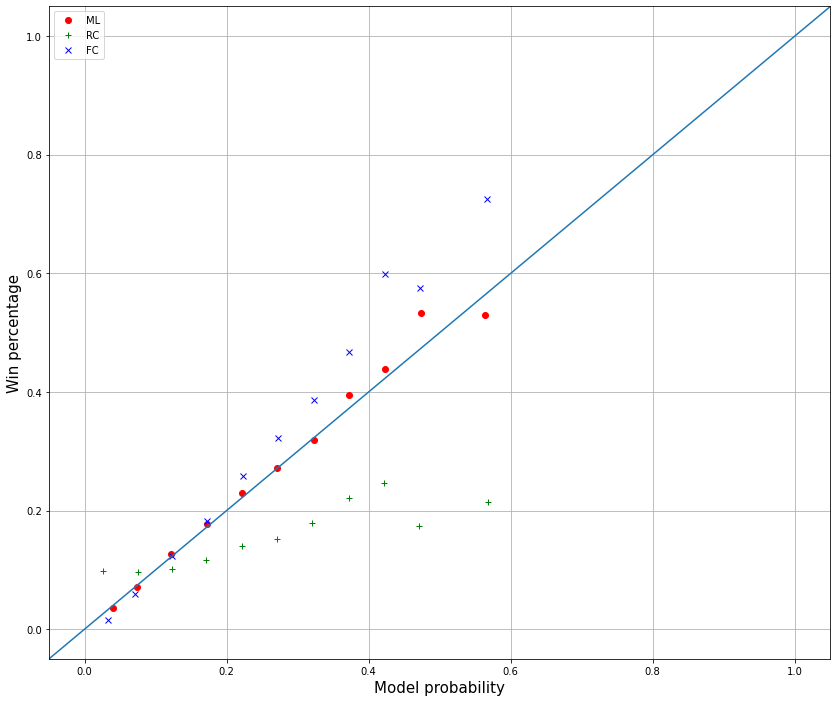

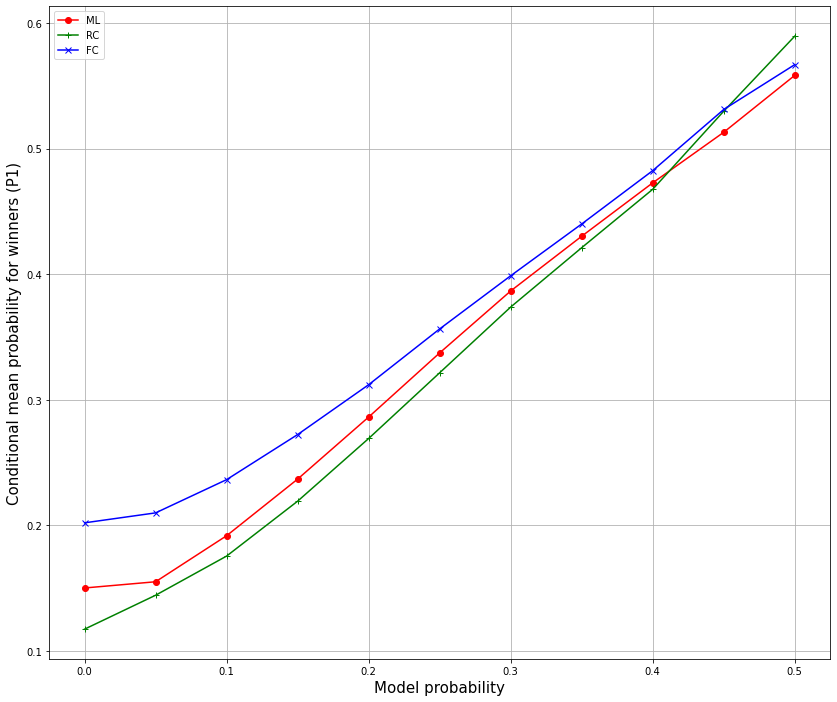

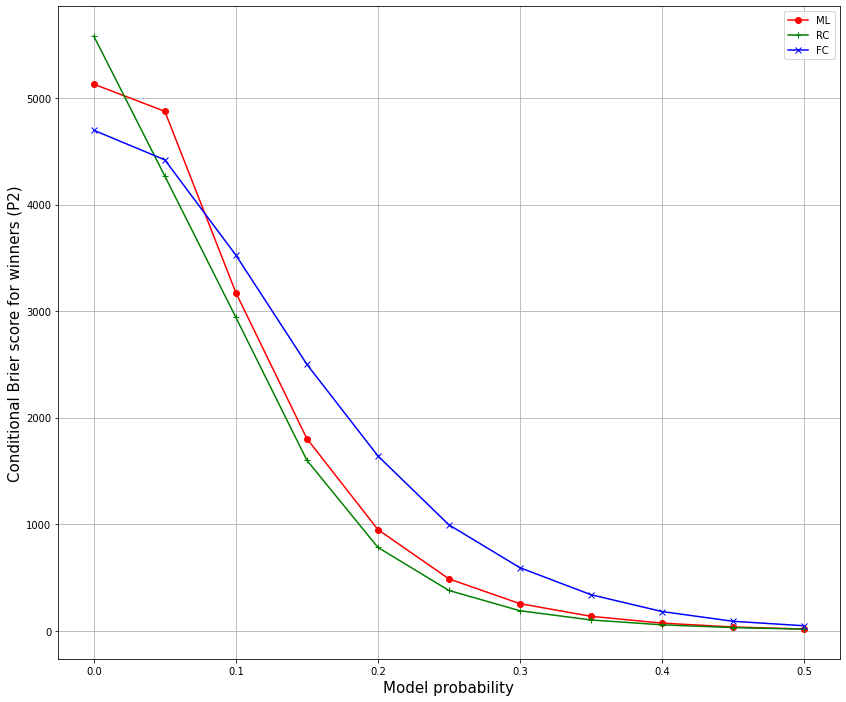

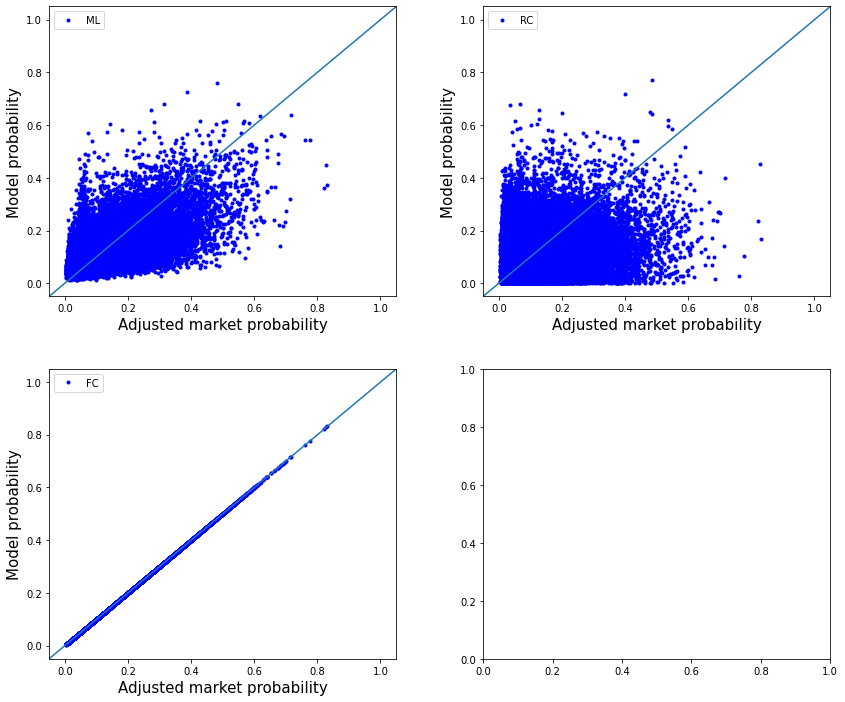

In [898]:
my_model_assessment.show_diagnostic_plots()

# Demonstrate calculating wagering strategy payoffs for single race

In [899]:
def pick_hi_mod_prob(augmented_runners_single_race):
    stakes = pd.Series(np.full(len(augmented_runners_single_race), 0, np.float64), index=augmented_runners_single_race.index)
    max_mod_prob = np.max(augmented_runners_single_race.mod_prob)
    i = augmented_runners_single_race[augmented_runners_single_race.mod_prob == max_mod_prob].index[0]
    stakes[i] = 1
    return stakes

In [900]:
my_1st_strategy = WageringStrategy(my_multinomial_logit, pick_hi_mod_prob, 'PickHiModProb')
my_1st_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.558904,1.0,2.08
1,440447,720097,1,21.00,0,0.091615,0.0,0.00
2,440447,738609,2,17.00,0,0.097166,0.0,0.00
3,440447,1663897,4,9.00,0,0.152579,0.0,0.00
4,440447,1783909,5,81.00,0,0.099735,0.0,0.00


In [901]:
my_2nd_strategy = WageringStrategy(my_random_choice, pick_hi_mod_prob, 'PickHiModProb')
my_2nd_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.133195,0.0,0.0
1,440447,720097,1,21.00,0,0.159189,0.0,0.0
2,440447,738609,2,17.00,0,0.317195,1.0,0.0
3,440447,1663897,4,9.00,0,0.123507,0.0,0.0
4,440447,1783909,5,81.00,0,0.266914,0.0,0.0


In [902]:
my_3rd_strategy = WageringStrategy(my_favourite_choice, pick_hi_mod_prob, 'PickHiModProb')
my_3rd_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.692777,1.0,2.08
1,440447,720097,1,21.00,0,0.065499,0.0,0.00
2,440447,738609,2,17.00,0,0.080054,0.0,0.00
3,440447,1663897,4,9.00,0,0.144098,0.0,0.00
4,440447,1783909,5,81.00,0,0.017573,0.0,0.00


# Demonstrate calculating wagering strategy payoffs for multiple races

In [903]:
my_1st_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_1st_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.558904,1.0,2.08
1,440447,720097,1,21.00,0,0.091615,0.0,0.00
2,440447,738609,2,17.00,0,0.097166,0.0,0.00
3,440447,1663897,4,9.00,0,0.152579,0.0,0.00
4,440447,1783909,5,81.00,0,0.099735,0.0,0.00


In [904]:
my_2nd_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_2nd_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.327777,1.0,2.08
1,440447,720097,1,21.00,0,0.018351,0.0,0.00
2,440447,738609,2,17.00,0,0.268064,0.0,0.00
3,440447,1663897,4,9.00,0,0.313836,0.0,0.00
4,440447,1783909,5,81.00,0,0.071973,0.0,0.00


In [905]:
my_3rd_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_3rd_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.692777,1.0,2.08
1,440447,720097,1,21.00,0,0.065499,0.0,0.00
2,440447,738609,2,17.00,0,0.080054,0.0,0.00
3,440447,1663897,4,9.00,0,0.144098,0.0,0.00
4,440447,1783909,5,81.00,0,0.017573,0.0,0.00


# Demonstrate wagering strategy assessment

In [906]:
my_strategy_assessment = WageringStrategyAssessment([my_1st_strategy, my_2nd_strategy, my_3rd_strategy], runners[['race_id', 'meeting_date', 'runner_id', 'stall_number', 'win', 'adj_mkt_prob']])
display(my_strategy_assessment.assessment)
my_strategy_assessment.perform_assessment()

,race_id,meeting_date,runner_id,stall_number,win,adj_mkt_prob,PickHiModProb(ML)_mod_prob,PickHiModProb(ML)_strat_stake,PickHiModProb(ML)_strat_payoff,PickHiModProb(RC)_mod_prob,PickHiModProb(RC)_strat_stake,PickHiModProb(RC)_strat_payoff,PickHiModProb(FC)_mod_prob,PickHiModProb(FC)_strat_stake,PickHiModProb(FC)_strat_payoff
0,440447,2013-01-01,568961,3,1,0.692777,0.558904,1.0,2.08,0.327777,1.0,2.08,0.692777,1.0,2.08
1,440447,2013-01-01,720097,1,0,0.065499,0.091615,0.0,0.00,0.018351,0.0,0.00,0.065499,0.0,0.00
2,440447,2013-01-01,738609,2,0,0.080054,0.097166,0.0,0.00,0.268064,0.0,0.00,0.080054,0.0,0.00
3,440447,2013-01-01,1663897,4,0,0.144098,0.152579,0.0,0.00,0.313836,0.0,0.00,0.144098,0.0,0.00
4,440447,2013-01-01,1783909,5,0,0.017573,0.099735,0.0,0.00,0.071973,0.0,0.00,0.017573,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56736,619008,2015-10-14,2068719,10,0,0.038529,0.067727,0.0,0.00,0.120078,1.0,0.00,0.038529,0.0,0.00
56737,619008,2015-10-14,2072533,3,0,0.043247,0.051757,0.0,0.00,0.091679,0.0,0.00,0.043247,0.0,0.00
56738,619008,2015-10-14,2106312,4,0,0.084765,0.071175,0.0,0.00,0.068943,0.0,0.00,0.084765,0.0,0.00
56739,619008,2015-10-14,2120288,13,0,0.012465,0.103377,0.0,0.00,0.061345,0.0,0.00,0.012465,0.0,0.00


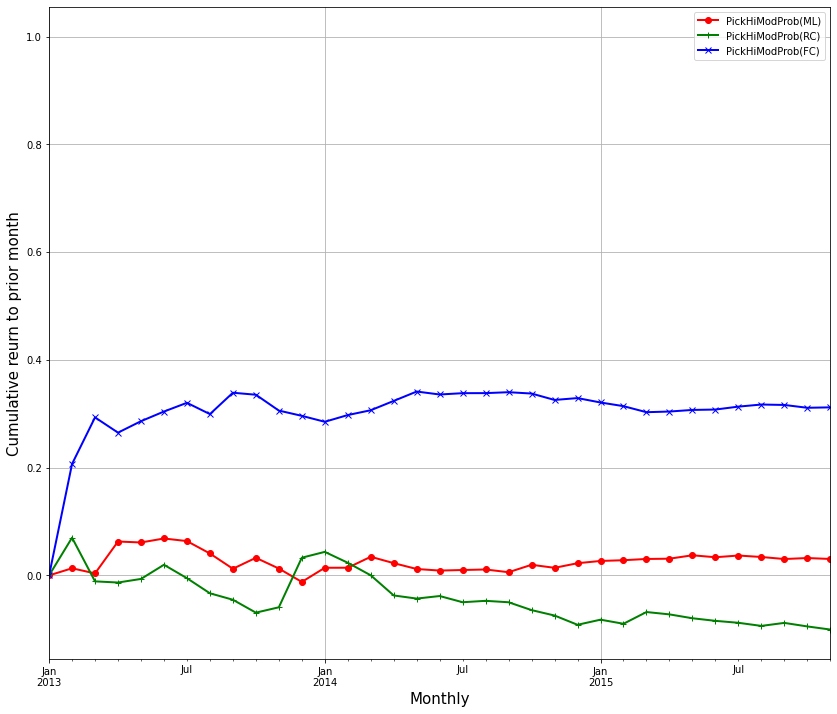

In [907]:
my_strategy_assessment.plot_cumulative_return()

In [911]:
my_strategy_assessment.monthly_assessment['PickHiModProb(ML)']

,as_of,strat_stake,strat_payoff,strat_ret,strat_stake_cumsum,strat_payoff_cumsum,strat_cumret
0,2013-01-01,0.0,0.00,0.000000,0.0,0.00,0.000000
1,2013-02-01,332.0,336.40,0.013253,332.0,336.40,0.013253
2,2013-03-01,260.0,257.80,-0.008462,592.0,594.20,0.003716
3,2013-04-01,278.0,330.52,0.188921,870.0,924.72,0.062897
4,2013-05-01,223.0,235.09,0.054215,1093.0,1159.81,0.061125
5,2013-06-01,100.0,114.93,0.149300,1193.0,1274.74,0.068516
6,2013-07-01,93.0,93.16,0.001720,1286.0,1367.90,0.063686
7,2013-08-01,81.0,54.71,-0.324568,1367.0,1422.61,0.040680
8,2013-09-01,111.0,73.63,-0.336667,1478.0,1496.24,0.012341
9,2013-10-01,163.0,198.39,0.217117,1641.0,1694.63,0.032681
